# Project 2:  Holiday weather

by Rob Griffiths, 11 September 2015, updated 11 April 2017

This is the project notebook for Week 2 of The Open University's [_Learn to code for Data Analysis_](http://futurelearn.com/courses/learn-to-code) course.

There is nothing I like better than taking a holiday. In the winter I like to have a two week break in a country where I can be guaranteed sunny dry days. In the summer I like to have two weeks off relaxing in my garden in London. However I'm often disappointed because I pick a fortnight when the weather is dull and it rains. So in this project I am going to use the historic weather data from the Weather Underground for London to try to predict two good weather weeks to take off as holiday next summer. Of course the weather in the summer of 2016 may be very different to 2014 but it should give me some indication of when would be a good time to take a summer break.

## Env

In [1]:
import sys
sys.version

'3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]'

In [2]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.1.final.0
python-bits: 64
OS: Windows
OS-release: 7
machine: AMD64
processor: Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None

pandas: 0.20.1
pytest: 3.0.7
pip: 9.0.1
setuptools: 27.2.0
Cython: 0.25.2
numpy: 1.12.1
scipy: 0.19.0
xarray: None
IPython: 5.3.0
sphinx: 1.5.6
patsy: 0.4.1
dateutil: 2.6.0
pytz: 2017.2
blosc: None
bottleneck: 1.2.1
tables: 3.2.2
numexpr: 2.6.2
feather: None
matplotlib: 2.0.2
openpyxl: 2.4.7
xlrd: 1.0.0
xlwt: 1.2.0
xlsxwriter: 0.9.6
lxml: 3.7.3
bs4: 4.6.0
html5lib: 0.999
sqlalchemy: 1.1.9
pymysql: None
psycopg2: None
jinja2: 2.9.6
s3fs: None
pandas_gbq: None
pandas_datareader: 0.4.0


## Getting the data

Weather Underground keeps historical weather data collected in many airports around the world. Right-click on the following URL and choose 'Open Link in New Window' (or similar, depending on your browser):

http://www.wunderground.com/history

When the new page opens start typing 'London' in the 'Location' input box and when the pop up menu comes up with the option 'London, United Kingdom' select it and then click on 'Submit'. 

When the next page opens with London Heathrow data, click on the 'Custom' tab and select the time period From: 1 January 2014 to: 31 December 2014 and then click on 'Get History'. The data for that year should then be displayed further down the page. 

The data can be obtained month by month in CSV format. For example, the January 2014 data is available at this URL:

https://www.wunderground.com/history/airport/LHR/2014/1/1/MonthlyHistory.html?format=1

where LHR is the airport code. Changing the first 1 to 2, 3, etc. will show instead the data for February, March, etc. You can also change the 2014 in the URL to another year. 

The date column heading will be the timezone, e.g. 'GMT' (Greenwich Mean Time) for London, or the time offset, e.g. '-02'. It may even change throughout the year. For example, Delhi (aiport code DEL) is '+0430' from March to August and '+0330' in the other months.

You can copy each month's data directly from the browser to a text editor like Notepad or TextEdit, to obtain a single file with as many months as you wish.

Weather Underground has changed in the past the way it provides data and may do so again in the future. 
I have therefore collated the whole 2014 data in the provided 'London_2014.csv' file. 

Now load the CSV file into a dataframe making sure that any extra spaces are skipped:

In [3]:
delhi = read_csv('Delhi_DEL_2014.csv', skipinitialspace=True)
delhi.head()

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees<br />
0,2014-1-1,-4,-7,-9,-9,-10,-11,82,70,58,...,2,2,2,6,2,NaN,0.0,8.0,NaN,-1<br />
1,2014-1-2,-1,-4,-8,-6,-8,-11,75,69,53,...,3,2,2,6,0,NaN,0.0,8.0,NaN,-1<br />
2,2014-1-3,1,-3,-8,-4,-6,-10,84,72,54,...,3,2,2,6,0,NaN,0.0,8.0,NaN,-1<br />
3,2014-1-4,-1,-2,-3,-4,-5,-6,80,74,64,...,8,4,2,14,2,NaN,0.0,8.0,NaN,-1<br />
4,2014-1-5,-1,-3,-6,-4,-6,-8,93,79,71,...,6,3,2,14,2,NaN,0.0,8.0,Snow,-1<br />


## Cleaning the data
First we need to clean up the data. I'm not going to make use of `'WindDirDegrees'` in my analysis, but you might in yours so we'll rename `'WindDirDegrees< br />'` to `'WindDirDegrees'`. 

In [4]:
delhi = delhi.rename(columns={'WindDirDegrees<br />' : 'WindDirDegrees'})

remove the  `< br />`  html line breaks from the values in the `'WindDirDegrees'` column. 

In [5]:
delhi['WindDirDegrees'] = delhi['WindDirDegrees'].str.rstrip('<br />')

and change the values in the `'WindDirDegrees'` column to `float64`:

In [6]:
delhi['WindDirDegrees'] = delhi['WindDirDegrees'].astype('float64')   

We definitely need to change the values in the `'GMT'` column into values of the `datetime64`  date type.

In [7]:
delhi['Date'] = to_datetime(delhi['Date'])

We also need to change the index from the default to the `datetime64` values in the `'Date'` column so that it is easier to pull out rows between particular dates and display more meaningful graphs: 

In [8]:
delhi.index = delhi['Date']

In [9]:
delhi.head()

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,2014-01-01,-4,-7,-9,-9,-10,-11,82,70,58,...,2,2,2,6,2,NaN,0.0,8.0,NaN,-1.0
2014-01-02,2014-01-02,-1,-4,-8,-6,-8,-11,75,69,53,...,3,2,2,6,0,NaN,0.0,8.0,NaN,-1.0
2014-01-03,2014-01-03,1,-3,-8,-4,-6,-10,84,72,54,...,3,2,2,6,0,NaN,0.0,8.0,NaN,-1.0
2014-01-04,2014-01-04,-1,-2,-3,-4,-5,-6,80,74,64,...,8,4,2,14,2,NaN,0.0,8.0,NaN,-1.0
2014-01-05,2014-01-05,-1,-3,-6,-4,-6,-8,93,79,71,...,6,3,2,14,2,NaN,0.0,8.0,Snow,-1.0


## Finding a summer break

According to meteorologists, summer extends for the whole months of June, July, and August in the northern hemisphere and the whole months of December, January, and February in the southern hemisphere. So as I'm in the northern hemisphere I'm going to create a dataframe that holds just those months using the `datetime` index, like this:

In [10]:
summer = delhi.loc[datetime(2014,5,1) : datetime(2014,8,31)]

I now look for the days with warm temperatures.

In [11]:
summer[summer['Mean TemperatureC'] >= 25].head()

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,...,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-20,2014-06-20,36,26,16,12,9,2,56,24,10,...,14,11,10,21,5,NaN,0.0,NaN,NaN,-1.0
2014-06-21,2014-06-21,37,27,17,12,7,0,51,25,5,...,19,14,10,23,6,NaN,0.0,NaN,NaN,167.0
2014-06-22,2014-06-22,37,27,17,9,5,-6,34,21,4,...,14,11,10,23,6,NaN,0.0,1.0,NaN,106.0
2014-06-23,2014-06-23,33,26,18,14,11,4,50,34,16,...,11,10,10,26,8,NaN,0.0,1.0,NaN,31.0
2014-06-24,2014-06-24,31,25,19,13,11,7,56,36,19,...,14,11,10,26,10,NaN,0.0,2.0,Thunderstorm,6.0


Summer 2014 was rather cool in London: there are no days with temperatures of 25 Celsius or higher. Best to see a graph of the temperature and look for the warmest period.

So next we tell Jupyter to display any graph created inside this notebook:

In [12]:
%matplotlib inline

Now let's plot the `'Mean TemperatureC'` for the summer:

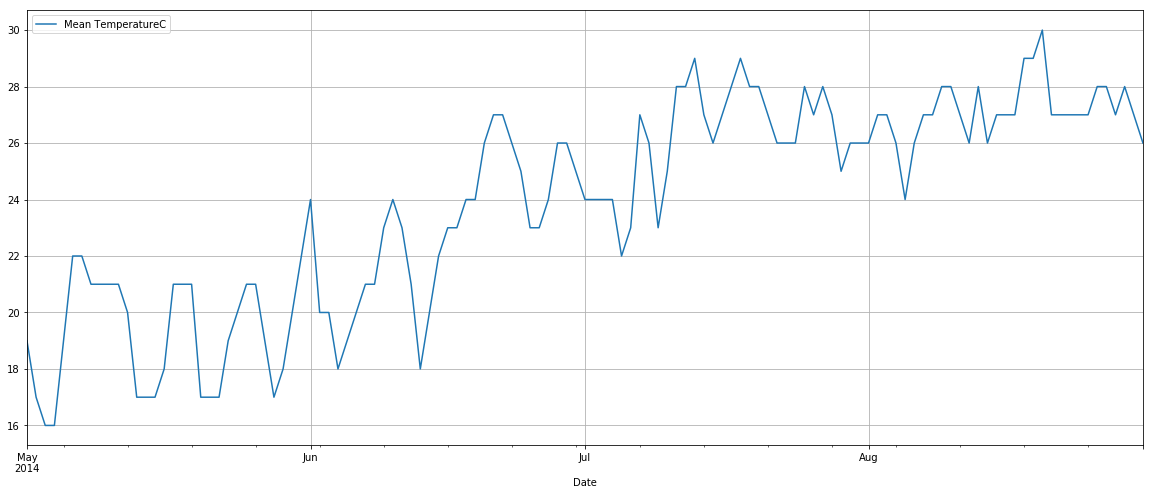

In [13]:
summer[['Mean TemperatureC']].plot(grid=True, figsize=(20,8));

Well looking at the graph the second half of July looks good for mean temperatures over 20 degrees C so let's also put precipitation on the graph too:

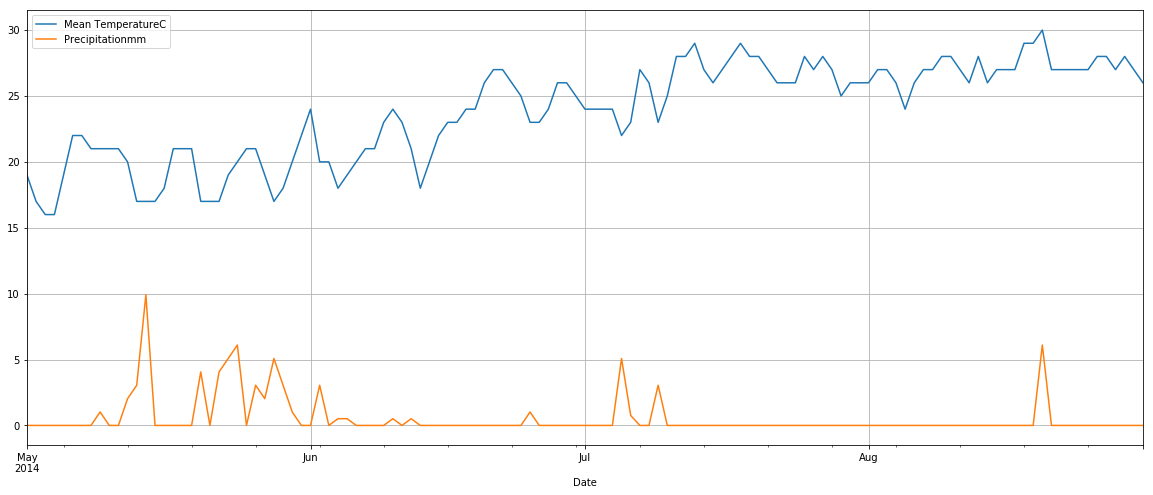

In [14]:
summer[['Mean TemperatureC', 'Precipitationmm']].plot(grid=True, figsize=(20,8));

The second half of July is still looking good, with just a couple of peaks showing heavy rain. Let's have a closer look by just plotting mean temperature and precipitation for July.  

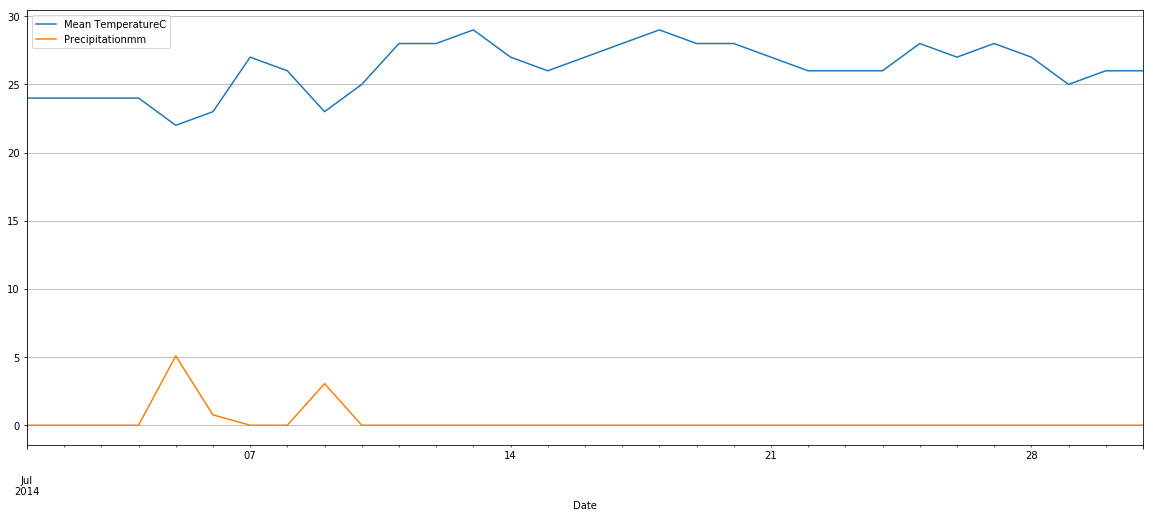

In [15]:
july = summer.loc[datetime(2014,7,1) : datetime(2014,7,31)]
july[['Mean TemperatureC', 'Precipitationmm']].plot(grid=True, figsize=(20,8));

Yes, second half of July looks pretty good, just two days that have significant rain, the 25th and the 28th and just one day when the mean temperature drops below 20 degrees, also the 28th.

## Conclusions

The graphs have shown the volatility of a British summer, but a couple of weeks were found when the weather wasn't too bad in 2014. Of course this is no guarantee that the weather pattern will repeat itself in future years. To make a sensible prediction we would need to analyse the summers for many more years. By the time you have finished this course you should be able to do that.